In [18]:
%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

import logging
from itertools import islice, cycle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from traffic.core import Traffic
from traffic.drawing import countries, rivers
from traffic.data import nm_airspaces
from traffic.core.projection import Lambert93

logger = logging.getLogger()
logger.setLevel(logging.INFO)


def plot(tc, sector):
    n_clusters_ = int(1 + tc.data.cluster.max())

    #  -- dealing with colours --
    color_cycle = cycle(
        ["#377eb8", "#ff7f00", "#4daf4a", "#f781bf"]
        + ["#a65628", "#984ea3", "#999999", "#e41a1c", "#dede00"]
    )

    colors = list(islice(color_cycle, n_clusters_))
    colors.append("#aaaaaa")  # color for outliers, if any

    # -- dealing with the grid --

    nb_cols = 3
    nb_lines = (1 + n_clusters_) // nb_cols + (((1 + n_clusters_) % nb_cols) > 0)

    def ax_iter(axes):
        if len(axes.shape) == 1:
            yield from axes
        if len(axes.shape) == 2:
            for ax_ in axes:
                yield from ax_

    with plt.style.context("traffic"):
        fig, ax = plt.subplots(
            nb_lines, nb_cols, subplot_kw=dict(projection=Lambert93())
        )

        for cluster, ax_ in zip(range(-1, n_clusters_), ax_iter(ax)):
            ax_.add_feature(countries())
            ax_.add_feature(rivers())

            tc.query(f"cluster == {cluster}").plot(ax_, color=colors[cluster])

            ax_.set_extent(nm_airspaces[sector])

            nm_airspaces[sector].plot(ax_, lw=2)

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# LFBBBDX (Bordeaux ACC)

In [4]:
def good_flight(flight):
    return flight.duration > pd.Timedelta("5 minutes")


t = Traffic.from_file("~/traffic/traffic/data/sample_opensky.pkl")
t_filtered = (
    t.assign(
        log_altitude=lambda df: df.altitude.apply(lambda x: np.log10(x) if x > 0 else x)
    )
    .clean_invalid()
    .assign_id()
    .filter_if(good_flight)
    .filter()
    .filter(altitude=53)
    .resample("5s")
    .resample(50)
    .eval(desc="preprocessing")
)

INFO:root:Clustering...
INFO:root:Cluster 0: 4 trajectories = 1.5% of the traffic
INFO:root:Cluster 1: 12 trajectories = 4.4% of the traffic
INFO:root:Cluster 2: 5 trajectories = 1.9% of the traffic
INFO:root:Cluster 3: 19 trajectories = 7.0% of the traffic
INFO:root:Cluster 4: 5 trajectories = 1.9% of the traffic
INFO:root:Cluster 5: 16 trajectories = 5.9% of the traffic
INFO:root:Cluster 6: 15 trajectories = 5.6% of the traffic
INFO:root:Cluster 7: 4 trajectories = 1.5% of the traffic
INFO:root:Cluster 8: 5 trajectories = 1.9% of the traffic
INFO:root:Cluster 9: 3 trajectories = 1.1% of the traffic
INFO:root:Cluster 10: 3 trajectories = 1.1% of the traffic
INFO:root:Cluster 11: 3 trajectories = 1.1% of the traffic
INFO:root:Cluster 12: 3 trajectories = 1.1% of the traffic
INFO:root:Cluster 13: 6 trajectories = 2.2% of the traffic
INFO:root:Cluster 14: 3 trajectories = 1.1% of the traffic
INFO:root:Cluster 15: 4 trajectories = 1.5% of the traffic
INFO:root:Cluster 16: 3 trajectories =

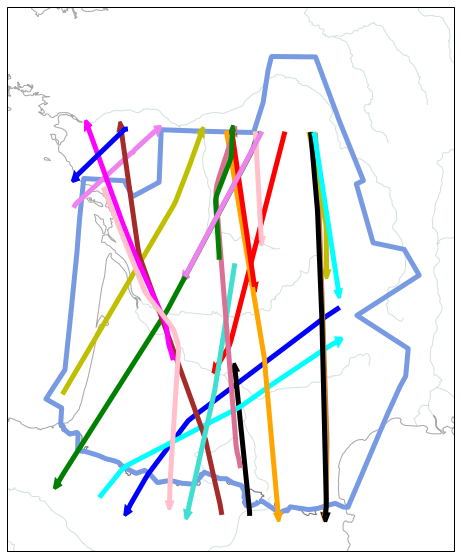

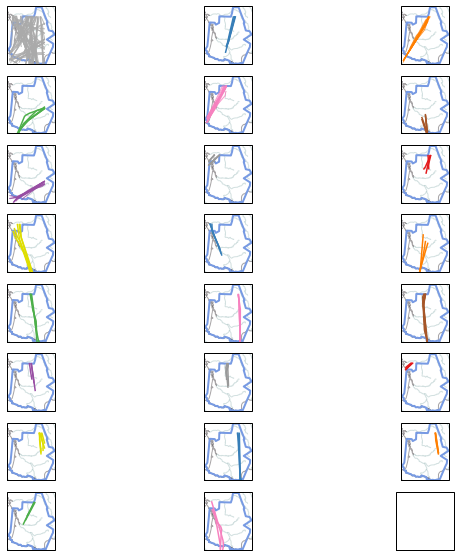

In [19]:
from sectflow.clustering import TrajClust

# features = ["x", "y"]  # 2D clustering
# features = ["x", "y", "latitude", "longitude"] # 2D clustering with lat/lon
features = ["x", "y", "altitude"]  # 3D clustering
# features = ["x", "y", "altitude", "log_altitude"]  # 3D clustering with log_altitude

tc = t_filtered.clustering(
    nb_samples=2,
    features=features,
    projection=Lambert93(),
    clustering=TrajClust(features, eps=0.5, min_cluster_size_ratio=0.01),
).fit_predict()

from sectflow.plot import clusters_plot2d

clusters_plot2d(
    nm_airspaces["LFBBBDX"], tc, 50, Lambert93()
)  # , scaler=StandardScaler())
plot(tc, "LFBBBDX")

# LS (Switzerland)

INFO:root:Clustering...
INFO:root:Cluster 0: 69 trajectories = 5.5% of the traffic
INFO:root:Cluster 1: 53 trajectories = 4.3% of the traffic
INFO:root:Cluster 2: 39 trajectories = 3.1% of the traffic
INFO:root:Cluster 3: 27 trajectories = 2.2% of the traffic
INFO:root:Cluster 4: 28 trajectories = 2.3% of the traffic
INFO:root:Cluster 5: 43 trajectories = 3.5% of the traffic
INFO:root:Cluster 6: 44 trajectories = 3.5% of the traffic
INFO:root:Cluster 7: 60 trajectories = 4.8% of the traffic
INFO:root:Cluster 8: 38 trajectories = 3.1% of the traffic
INFO:root:Cluster 9: 77 trajectories = 6.2% of the traffic
INFO:root:Cluster 10: 46 trajectories = 3.7% of the traffic
INFO:root:Cluster 11: 53 trajectories = 4.3% of the traffic
INFO:root:Cluster 12: 41 trajectories = 3.3% of the traffic
INFO:root:Cluster 13: 39 trajectories = 3.1% of the traffic
INFO:root:Cluster 14: 48 trajectories = 3.9% of the traffic
INFO:root:Cluster 15: 29 trajectories = 2.3% of the traffic
INFO:root:Cluster 16: 29 t

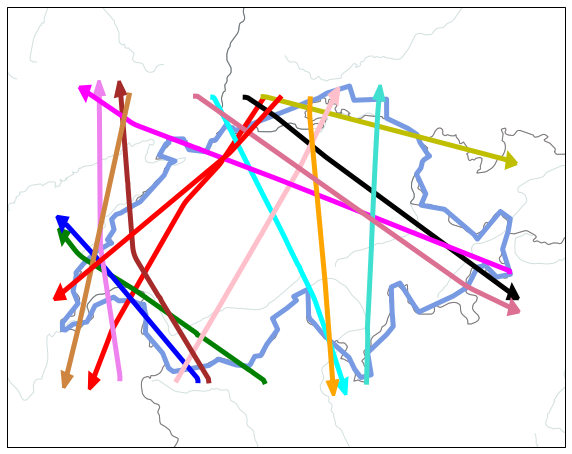

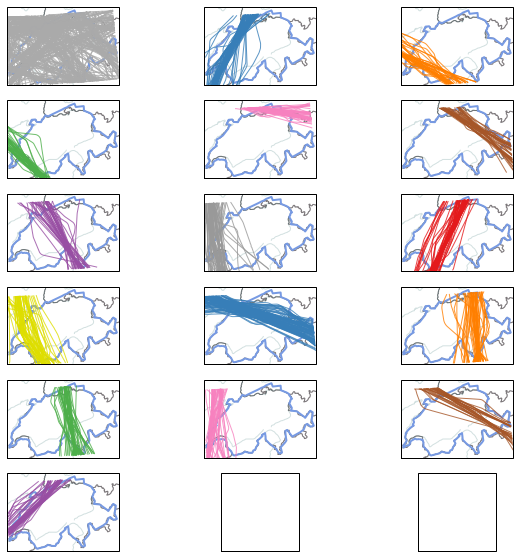

In [21]:
from traffic.data.samples import get_flight
from pathlib import Path

switzerland = get_flight(
    "switzerland", Path("~/traffic/traffic/traffic/data/samples/atm/")
)
import numpy as np

sw = (
    switzerland.assign(
        log_altitude=lambda df: df.altitude.apply(lambda x: np.log10(x) if x > 0 else x)
    )
    .assign_id()
    .eval()
)

from sectflow.clustering import TrajClust
from traffic.core.projection import CH1903

features = ["x", "y", "latitude", "longitude", "altitude", "log_altitude"]

tc = sw.clustering(
    nb_samples=2,
    features=features,
    projection=CH1903(),
    clustering=TrajClust(
        features,
        min_cluster_size_ratio=0.0115,
        # sub_min_cluster_size_ratio=0.01,
        eps=0.5,
        sub_eps=0.5,
    ),
).fit_predict()

from sectflow.plot import clusters_plot2d
from traffic.core.projection import EuroPP

clusters_plot2d(nm_airspaces["LS"], tc, 50, EuroPP(), plot_trajs=False)
plot(tc, "LS")